In [2]:
import numpy as np
from scipy import signal
import scipy.spatial.distance as distfuncs
import scipy.special as special
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from pathlib import Path

import sys
sys.path.append('../')
import irutilities as irutil

In [3]:
# Load ir data
sessionName = "data_s32_m441_npy"
sessionPath = Path('..').joinpath(sessionName)
posEval, posSrc, irAll = irutil.loadIR(sessionPath)

numEval = posEval.shape[0]
numSrc = posSrc.shape[0]

posEvalX = np.unique(posEval[:,0].round(4))
posEvalY = np.unique(posEval[:,1].round(4))
numEvalXY = (posEvalX.shape[0], posEvalY.shape[0])

# Sampling rate (original)
samplerate_raw = 48000

In [4]:
# Downsampling
downSampling = 6
irEval = signal.resample_poly(irAll, up=1, down=downSampling, axis=-1)
samplerate = samplerate_raw // downSampling
print('samplerate (Hz): ', samplerate)

posEvalXY, _, idxEvalXY = irutil.sortIR(posEval[:,0:2], irEval, numEvalXY, posEvalX, posEvalY)
print(idxEvalXY.shape)

# Transpose
irLen = 4096
irEval = np.transpose(irEval, (2,1,0))
irEval = irEval[0:irLen,:,:]

# IR length
#irLen = irEval.shape[0]
print('ir length:', irLen)

samplerate (Hz):  8000
(21, 21)
ir length: 4096


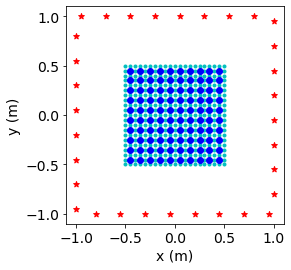

In [5]:
# Control points
xGrid = np.arange(np.min(posEvalX)+0.05, np.max(posEvalX), 0.1)
yGrid = np.arange(np.min(posEvalY)+0.05, np.max(posEvalY), 0.1)

xIdx = []
for ii in np.arange(xGrid.shape[0]):
    xIdx.append(np.where( np.isclose(posEval[:,0], xGrid[ii]) ))
yIdx = []
for ii in np.arange(yGrid.shape[0]):
    yIdx.append(np.where( np.isclose(posEval[:,1], yGrid[ii]) ))

idxMic = np.intersect1d(xIdx, yIdx)
numMic = idxMic.shape[0]
posMic = posEval[idxMic,:]

# IR at control points
irMic = irEval[:,idxMic,:]

# Plot geometry
plt.rcParams["font.size"] = 14

fig, ax = plt.subplots()
ax.scatter(posEval[:,0], posEval[:,1], marker='.', color='c')
ax.scatter(posMic[:,0], posMic[:,1], marker='o', color='b')
ax.scatter(posSrc[:,0], posSrc[:,1], marker='*', color='r')
ax.set_aspect('equal')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

# Plot IR
#fig, ax = plt.subplots()
#ax.plot(irMic[:,0,0])
#plt.xlabel('Sample')
#plt.show()

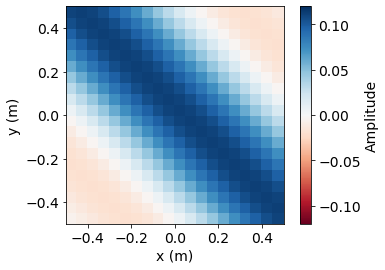

In [8]:
# FFT parameters
fftlen = 16384
freq = np.arange(1,int(fftlen/2)+1)/fftlen*samplerate
c = 341.0
k = 2.0 * np.pi * freq / c

# Filter parameters
smplShift = 4096
filterLen = 8192

# Lowpass filter
maxFreq = 500
h = signal.firwin(numtaps=64, cutoff=maxFreq, fs=samplerate)

# Desired sound field
pwAng = (np.pi/4, np.pi/2)
kVec = k[:,None] * np.array([np.cos(pwAng[0])*np.sin(pwAng[1]), np.sin(pwAng[0])*np.sin(pwAng[1]), np.cos(pwAng[1])])[None,:]
des = np.exp(- 1j * kVec @ posMic.T)

synTrue_f = np.exp(- 1j * kVec @ posEval.T)
synTrue_f = np.concatenate( (np.zeros((1,numEval)), synTrue_f, synTrue_f[int(fftlen/2)-2::-1,:].conj()) )
synTrue = np.fft.ifft(synTrue_f, n=fftlen, axis=0).real
synTrue = np.concatenate((synTrue[fftlen-smplShift:fftlen,:], synTrue[:fftlen-smplShift,:]))

synTrue = signal.filtfilt(h, 1, synTrue, axis=0)
distTrue = synTrue[:,idxEvalXY]

# Draw pressure distribution
tIdx = smplShift

xx, yy = np.meshgrid(posEvalX, posEvalY)

fig, ax = plt.subplots()
ax = plt.axes()
color = plt.pcolor(xx, yy, distTrue[tIdx,:,:], cmap='RdBu', vmin=-0.12, vmax=0.12)
ax.set_aspect('equal')
cbar=plt.colorbar(color)
cbar.set_label('Amplitude')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()


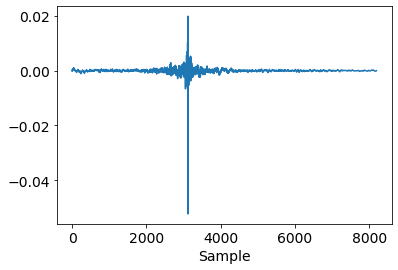

In [9]:
# Pressure matching
tfMic = np.fft.fft(irMic, n=fftlen, axis=0)
G = tfMic[1:int(fftlen/2)+1,:,:]

# Regularization parameter
reg = 1e-3

drvPM = np.squeeze( np.linalg.inv(np.transpose(G.conj(), (0,2,1)) @ G + reg * np.eye(numSrc)) @ np.transpose(G.conj(), (0,2,1)) @ des[:,:,None] )
drvPM = np.concatenate( (np.zeros((1,numSrc)), drvPM, drvPM[int(fftlen/2)-2::-1,:].conj()) )

filterPM = np.fft.ifft(drvPM, n=fftlen, axis=0).real
filterPM = np.concatenate((filterPM[fftlen-smplShift:fftlen,:], filterPM[:filterLen-smplShift,:]))

# Plot filter
fig, ax = plt.subplots()
ax.plot(filterPM[:,0])
plt.xlabel('Sample')
plt.show()


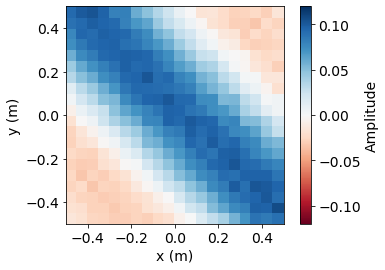

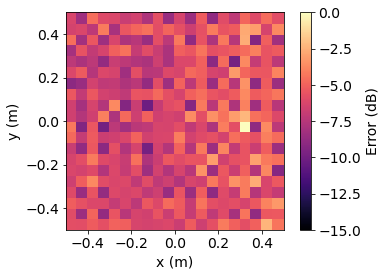

In [12]:
# Lowpass
sigPM = signal.filtfilt(h, 1, filterPM, axis=0)

# Convolution
sigPM_f = np.fft.fft(sigPM, n=fftlen, axis=0)
tfEval = np.fft.fft(irEval, n=fftlen, axis=0)
synPM = np.fft.ifft(tfEval @ sigPM_f[:,:,None], n=fftlen, axis=0).real
distPM = np.squeeze(synPM[:,idxEvalXY])
errPM = np.sum( np.abs(distPM - distTrue) ** 2, axis=0) / np.sum( np.abs(distTrue) ** 2, axis=0)

# Draw pressure distribution
fig, ax = plt.subplots()
ax = plt.axes()
color = plt.pcolor(xx, yy, distPM[tIdx,:,:], cmap='RdBu', vmin=-0.12, vmax=0.12)
ax.set_aspect('equal')
cbar=plt.colorbar(color)
cbar.set_label('Amplitude')
plt.xlabel('x (m)')
plt.ylabel('y (m)')

# Draw error distribution
fig, ax = plt.subplots()
ax = plt.axes()
color = plt.pcolor(xx, yy, 10 * np.log10(errPM), cmap='magma', vmin=-12.0, vmax=0.0)
ax.set_aspect('equal')
cbar=plt.colorbar(color)
cbar.set_label('Error (dB)')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()